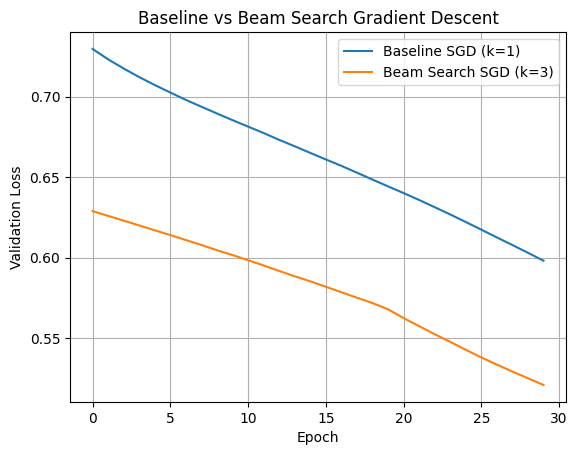

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import copy
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Dataset setup
X, y = make_classification(n_samples=300, n_features=10, n_informative=7,
                           n_redundant=3, n_classes=2, random_state=42)
X = StandardScaler().fit_transform(X)
y = y.astype(np.float32)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                         torch.tensor(y_train, dtype=torch.float32).unsqueeze(1))
val_ds = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                       torch.tensor(y_val, dtype=torch.float32).unsqueeze(1))

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64)

# Simple model
class TinyNet(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Helper to evaluate validation loss
def evaluate(model, val_loader, criterion):
    model.eval()
    with torch.no_grad():
        total_loss = 0
        for xb, yb in val_loader:
            preds = model(xb)
            total_loss += criterion(preds, yb).item()
    return total_loss / len(val_loader)

# Beam-style training
def train_beam_search(train_loader, val_loader, input_dim, k=3, epochs=30, lr=0.01, noise=0.01):
    criterion = nn.BCELoss()
    beams = [TinyNet(input_dim) for _ in range(k)]
    optimizers = [optim.SGD(b.parameters(), lr=lr) for b in beams]
    val_losses = []

    for epoch in range(epochs):
        for i in range(k):
            beams[i].train()
            for xb, yb in train_loader:
                optimizers[i].zero_grad()
                preds = beams[i](xb)
                loss = criterion(preds, yb)
                loss.backward()

                # Add noise to gradients
                for p in beams[i].parameters():
                    if p.grad is not None:
                        p.grad += noise * torch.randn_like(p.grad)

                optimizers[i].step()

        # Evaluate all beam models
        scored_beams = [(evaluate(b, val_loader, criterion), b) for b in beams]
        scored_beams.sort(key=lambda x: x[0])
        beams = [copy.deepcopy(b) for _, b in scored_beams[:k]]  # keep top-k
        optimizers = [optim.SGD(b.parameters(), lr=lr) for b in beams]

        val_losses.append(scored_beams[0][0])  # track best loss

    return beams[0], val_losses

# Train baseline
baseline_model = TinyNet(input_dim=10)
baseline_model, baseline_val_losses = train_beam_search(train_loader, val_loader, input_dim=10, k=1, epochs=30)

# Train beam search
beam_model, beam_val_losses = train_beam_search(train_loader, val_loader, input_dim=10, k=3, epochs=30)

# Plot comparison
plt.plot(baseline_val_losses, label="Baseline SGD (k=1)")
plt.plot(beam_val_losses, label="Beam Search SGD (k=3)")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Baseline vs Beam Search Gradient Descent")
plt.legend()
plt.grid(True)
plt.show()
